In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [ ]:
ex =  torch.load('ex_flattened_images.pt')
control =  torch.load('control_flattened_images.pt')
sd =  torch.load('sd_flattened_images.pt')
cosine_centroid = torch.load('cosine_centroid_tensor.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_22344\4250809734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex =  torch.load('ex_flattened_images.pt')
C:\Users\k54739\

In [3]:
print(ex.shape)
print(control.shape)
print(sd.shape)
print(cosine_centroid.shape)


torch.Size([29, 27648])
torch.Size([120, 27648])
torch.Size([103, 27648])
torch.Size([1, 27648])


In [4]:
import torch

def normalize_tensor(tensor, dim=1):
    """
    Normalize a PyTorch tensor along the specified dimension.
    
    Args:
        tensor (torch.Tensor): Input tensor to normalize (e.g., shape [N, D]).
        dim (int): Dimension along which to normalize. Default is 1 (rows).
    
    Returns:
        torch.Tensor: Normalized tensor with the same shape as input.
    """
    # Compute the L2 norm along the specified dimension
    norm = torch.norm(tensor, p=2, dim=dim, keepdim=True)
    
    # Avoid division by zero
    norm = torch.clamp(norm, min=1e-8)
    
    # Normalize the tensor
    normalized_tensor = tensor / norm
    return normalized_tensor


In [5]:
ex[0].shape

torch.Size([27648])

In [8]:
# Normalize each group
normalized_ex = normalize_tensor(ex, dim=1)  # Normalize each row
normalized_control = normalize_tensor(control, dim=1)
normalized_sd = normalize_tensor(sd, dim=1)
normalised_cosine_centroid = cosine_centroid

# Print shapes to verify
print("Normalized shapes:")
print(normalized_ex.shape)  # Should match ex.shape
print(normalized_control.shape)  # Should match control.shape
print(normalized_sd.shape) 
print(normalised_cosine_centroid.shape) 


Normalized shapes:
torch.Size([29, 27648])
torch.Size([120, 27648])
torch.Size([103, 27648])
torch.Size([1, 27648])


In [ ]:
#check for nomralisation

import numpy as np

# Calculate the L2 norm of each row in exp_np_norm
norms = np.linalg.norm(cosine_centroid, axis=1)

# Check if all norms are close to 1
if np.allclose(norms, 1.0, atol=1e-6):
    print("All feature vectors are normalized.")
else:
    print("Some feature vectors are not normalized.")
    print("Norms:", norms)


In [9]:
import torch
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(centroid, groups, group_names, bins=20):
    """
    Calculate cosine distances from a centroid to each vector in multiple groups and plot distributions.
    
    Args:
        centroid (torch.Tensor): Normalized centroid tensor of shape [1, D].
        groups (list of torch.Tensor): List of normalized tensors, each group of shape [N, D].
        group_names (list of str): Names of the groups (e.g., ["Control", "Exploded", "Single Dose"]).
        bins (int): Number of bins for the histogram.
        
    Returns:
        dict: Dictionary containing cosine distances for each group.
    """
    assert len(groups) == len(group_names), "Each group must have a corresponding name"
    
    cosine_distances = {}
    
    # Calculate cosine distances for each group
    for group, name in zip(groups, group_names):
        # Ensure the centroid and group are on the same device
        centroid = centroid.to(group.device)
        
        # Calculate cosine similarity
        cosine_similarity = torch.nn.functional.cosine_similarity(group, centroid.expand_as(group), dim=1)
        
        # Convert to cosine distances
        distances = 1 - cosine_similarity
        
        # Store distances
        cosine_distances[name] = distances.cpu().numpy()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    for name, distances in cosine_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=name, edgecolor="black")
    
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()
    
    return cosine_distances


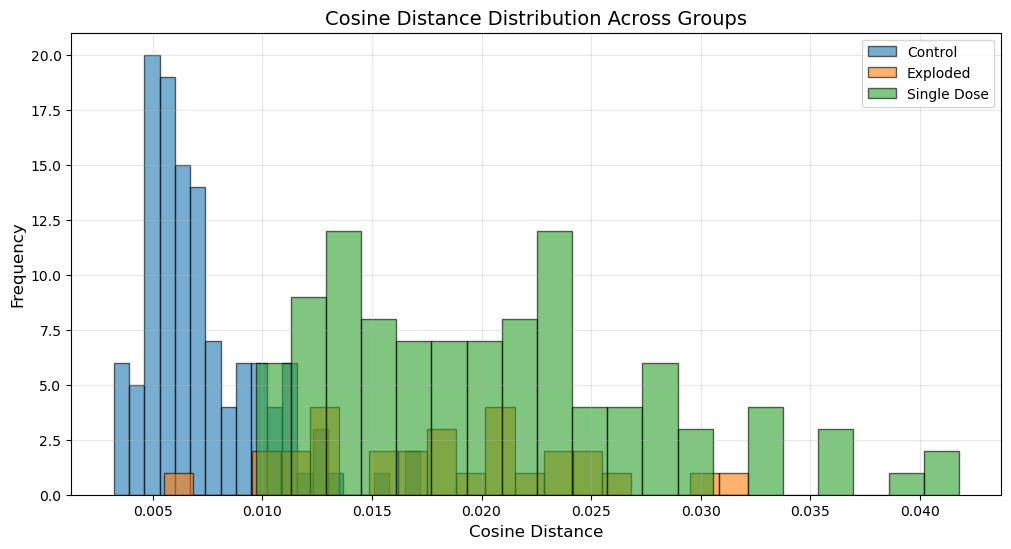

In [10]:
# Groups and names
groups = [normalized_control, normalized_ex, normalized_sd]
group_names = ["Control", "Exploded", "Single Dose"]

# Calculate distances and plot
cosine_distances = calculate_and_plot_cosine_distances(
    centroid=normalised_cosine_centroid,
    groups=groups,
    group_names=group_names,
    bins=20
)

# Access calculated distances
control_distances = cosine_distances["Control"]
exploded_distances = cosine_distances["Exploded"]
single_dose_distances = cosine_distances["Single Dose"]

In [11]:
control_distances.shape

(120,)

In [12]:
exploded_distances.shape

(29,)

In [13]:
single_dose_distances.shape

(103,)

In [ ]:
d